Open this notebook in Google Colab <a target="_blank" href="https://colab.research.google.com/github/neo4j-contrib/neo4j-spark-connector/blob/5.0/examples/neo4j_data_science.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Example of a Simple data science workflow with Neo4j and Spark

This notebook contains a set of examples that explains how the Neo4j Spark connector can fit in you Data Scinece workflow, how you can combine Spark Neo4j and the Graph Data Science library to extract insights from your data and mostly important it allows you to test your knowledge with a set of exercises after each section.

If you have any questions or problems feel free to write a post in the [Neo4j community forum](https://community.neo4j.com/) or in [Discord](https://discord.com/invite/neo4j).

If you want more exercises feel free to open an issue in the [GitHub repository](https://github.com/neo4j-contrib/neo4j-spark-connector).

Enjoy!

# Notes about this notebook

This code contains a simple data science workflow that combines Neo4j's Graph Data Science Library with the Neo4j Connector for Apache Spark.

Going forward you'll find code examples in:

* PySpark
* PySpark Pandas

You can choose to navigate by using one of them, or both, but we suggest you do one at time to ensure you understand the APIs.

# Create the sandbox instance

You can easily spin-up a Neo4j sandbox by click [here](https://sandbox.neo4j.com/?usecase=fraud-detection)

After that you'll be redirect in a webpage like this:

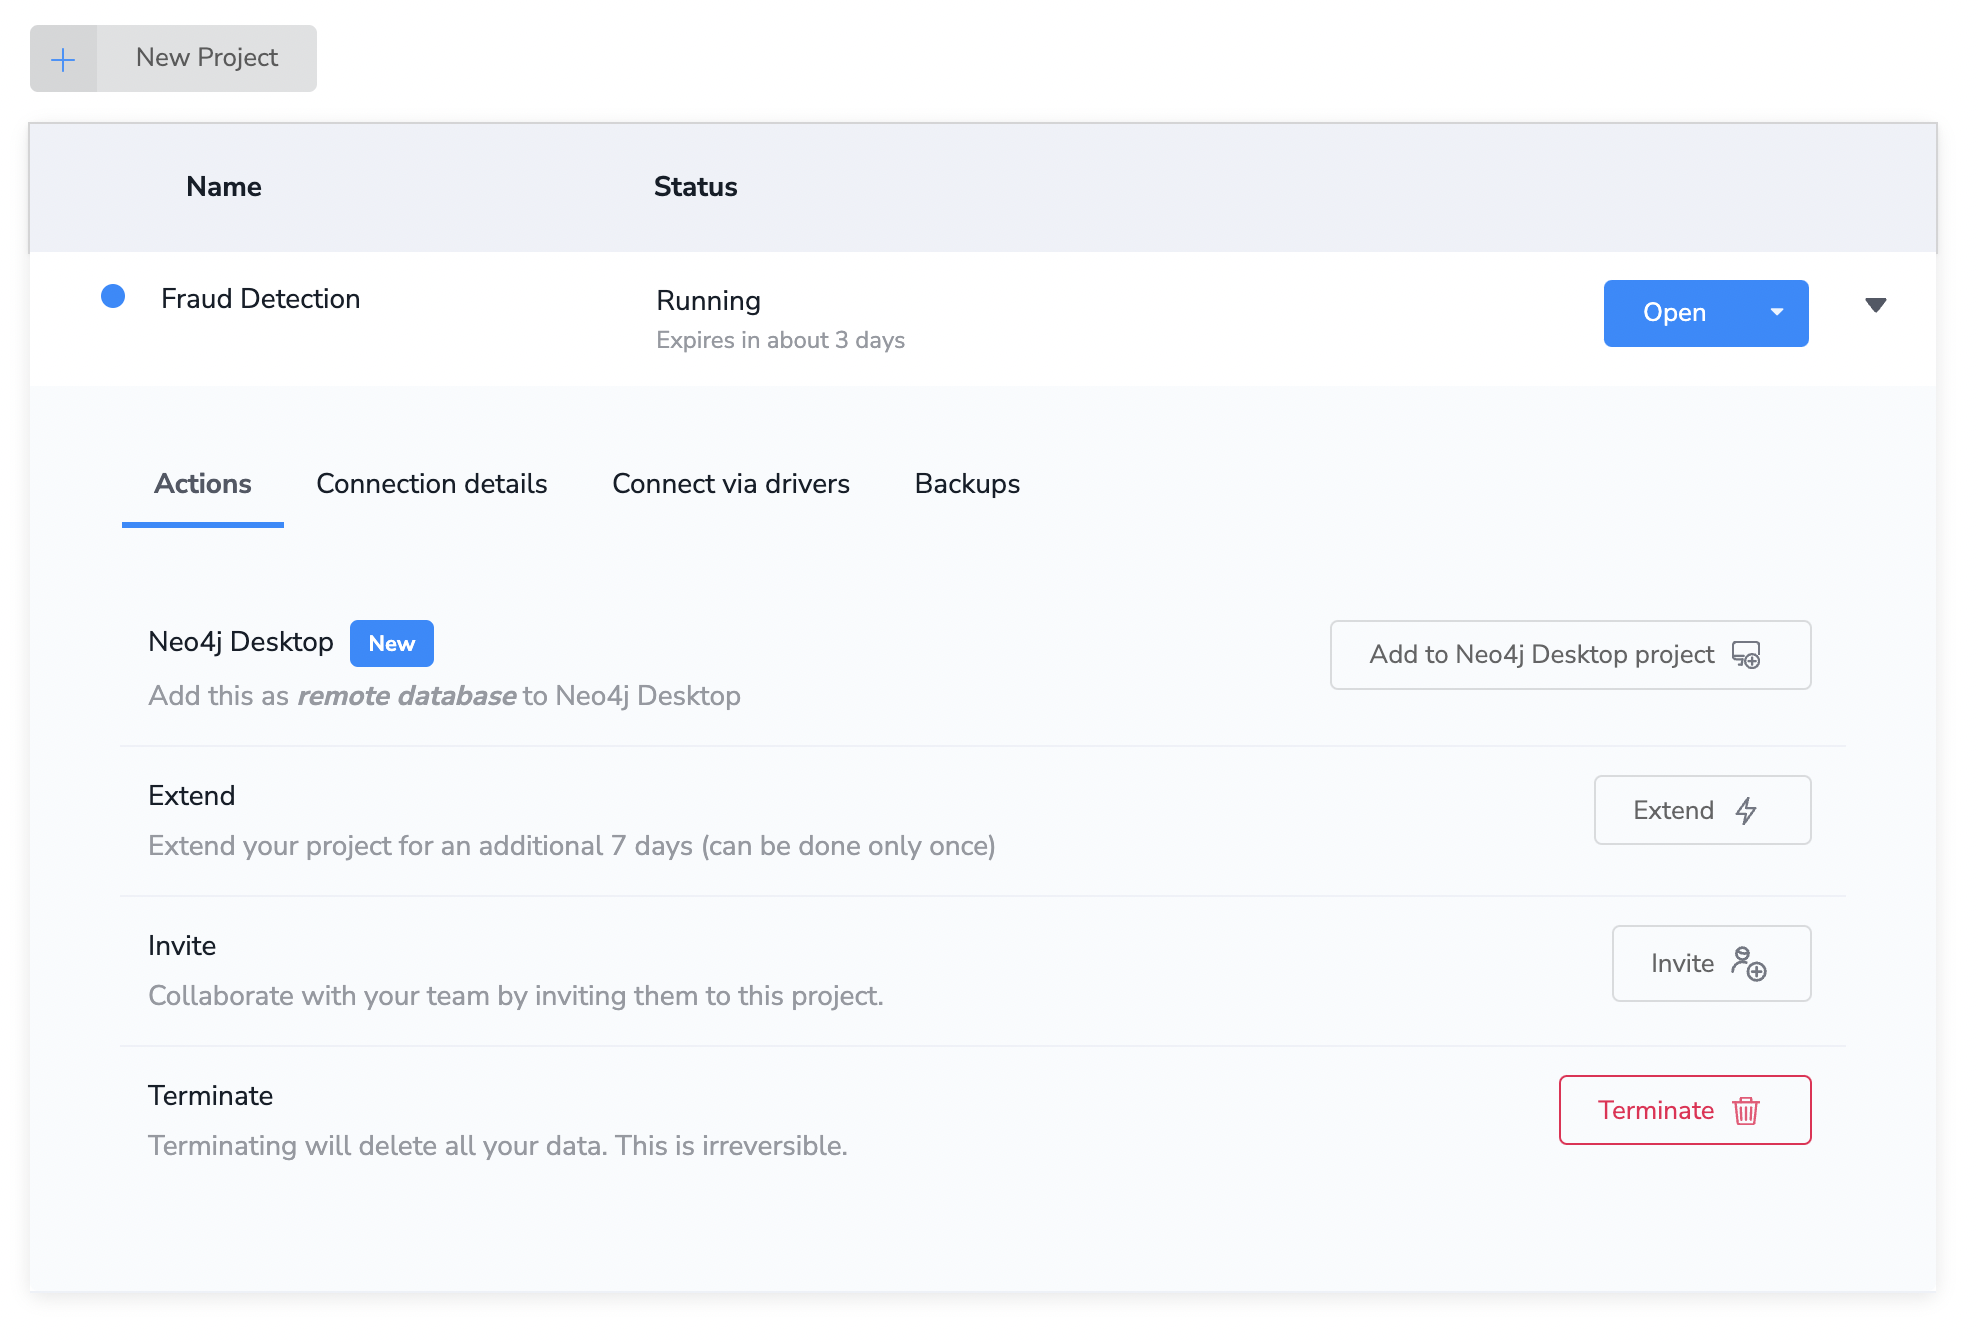

Please click in the **Connection details tab** and copy your connection parameters into the Python variables below

In [ ]:
neo4j_url = "" # put your neo4j url here

In [ ]:
neo4j_user = "neo4j" # put your neo4j user here

In [ ]:
neo4j_password = "" # put your neo4j password here

### Configure the Spark Environment

In [ ]:
!apt-get install openjdk-17-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://dlcdn.apache.org/spark/spark-3.3.3/spark-3.3.3-bin-hadoop3.tgz

In [ ]:
!tar xf spark-3.3.3-bin-hadoop3.tgz

In [ ]:
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.3-bin-hadoop3"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder
        .master('local[*]')
        .appName('Data science workflow with Neo4j and Spark')
        .config('spark.ui.port', '4050')
        # Just to show dataframes as tables
        #.config('spark.sql.repl.eagerEval.enabled', False)
        .config('spark.jars.packages', 'org.neo4j:neo4j-connector-apache-spark_2.12:5.1.0_for_spark_3')
        # As we're using always the same database instance we'll
        # define them as global variables
        # so we don't need to repeat them each time
        .config("neo4j.url", neo4j_url)
        .config("neo4j.authentication.type", "basic")
        .config("neo4j.authentication.basic.username", neo4j_user)
        .config("neo4j.authentication.basic.password", neo4j_password)
        .getOrCreate())
spark

In [ ]:
# import utility functions that we'll use in the notebook
from pyspark.sql.types import *
from pyspark.sql.functions import *

## Import PySpark Pandas

Pandas API on Apache Spark (PySpark) enables data scientists and data engineers to run their existing Pandas code on Spark. Prior to this API, you had to do a significant code rewrite from Pandas DataFrame to PySpark DataFrame which is time-consuming and error-prone.

In this notebook we'll use both PySpark Dataframes and and PySpark Pandas.

The only thing that we need to do is to import the library using the statement below.

In [ ]:
import pyspark.pandas as ps


## Exercises prerequisite

In this notebook we and going to test your knowledge. Some of the exercises require the Neo4j Python driver to check if the exercises are being solved correctly.

*Neo4j Python Driver is required only for verifying the exercises when you persist data from Spark to Neo4j*

**It's not required by the Spark connector!!!**

We'll use [Cy2Py](https://github.com/conker84/cy2py), a Jupyter extension that easily allows you to connect to Neo4j and visualize data from Jupyter notebooks.
For a detailed instruction about how to use it please dive into [this example](https://github.com/conker84/cy2py/blob/main/examples/Neo4j_Crime_Investigation_Dataset.ipynb)

In [ ]:
!pip install -q cy2py

let's load the extension

In [ ]:
%load_ext cy2py

You can query the database via **cy2py** in this simple way

In [ ]:
# define the colors for the nodes
colors = {
  ':Client': '#D18711',
  ':Bank': '#0541B2',
  ':Merchant': '#9E14AA',
  ':Mule': '#6113A3',
  ':CashIn': '#328918',
  ':CashOut': '#C1A23D',
  ':Debit': '#A32727',
  ':Payment': '#3B80C4',
  ':Transfer': '#088472',
  ':Transaction': '#D10B4F',
  ':Email': '#EA5D1E',
  ':SSN': '#707070',
  ':Phone': '#4B4444',
}

In [ ]:
%%cypher -u $neo4j_url -us $neo4j_user -pw $neo4j_password -co $colors
CALL apoc.meta.graph()

# Problem Definition


## What is Fraud?
Fraud occurs when an individual or group of individuals, or a business entity intentionally deceives another individual or business entity with misrepresentation of identity, products, services, or financial transactions and/or false promises with no intention of fulfilling them.

## Fraud Categories


### First-party Fraud
An individual, or group of individuals, misrepresent their identity or give false information when applying for a product or services to receive more favourable rates or when have no intention of repayment.

### Second-party Fraud
An individual knowingly gives their identity or personal information to another individual to commit fraud or someone is perpetrating fraud in his behalf.

### Third-party Fraud
An individual, or a group of individuals, create or use another person’s identity, or personal details, to open or takeover an account.

## The dataset

We will use Paysim dataset for the hands-on exercises. Paysim is a synthetic dataset that mimics real world mobile money transfer network.

For more information on the dataset, please visit this [blog page](https://www.sisu.io/posts/paysim/)

In [ ]:
%%cypher
CALL apoc.meta.graph()

There are five types of transactions in this database. List all transaction types and corresponding metrics by iterating over all the transactions.

#### Code in PySpark

In [ ]:
transaction_df = (spark.read
        .format('org.neo4j.spark.DataSource')
        .option('labels', ':Transaction')
        .load())

transaction_df_count = transaction_df.count()

transaction_df = (transaction_df.groupBy('<labels>')
  .count()
  .withColumnRenamed('<labels>', 'transaction'))

transaction_df = (transaction_df
      .withColumn('transaction', transaction_df['transaction'].getItem(0))
      .withColumn('% transactions', transaction_df['count'] / transaction_df_count))

transaction_df.show(truncate=False)

#### Code in PySpark Pandas

In [ ]:
transaction_ps = ps.read_spark_io(format="org.neo4j.spark.DataSource", options={"labels": "Transaction"})

transaction_ps_count = transaction_ps.count()[0] * 1.0

transaction_ps = (transaction_ps.groupby(['<labels>'])
                  .size()
                  .reset_index(name='% transactions'))

transaction_ps = transaction_ps.rename(columns={'<labels>': 'label'})

transaction_ps['% transactions'] = transaction_ps['% transactions'].astype(float).div(transaction_ps_count * 1.0)

transaction_ps.label = [x[0] for x in transaction_ps.label.to_numpy()]

transaction_ps

##### Plot the data
You can also use Python libraries like [Ploty](https://plotly.com/python/) to plot results

In [ ]:
import plotly.express as px

# we use to_pandas() in order to transform the PySpark Pandas to a real Pandas Dataframe
fig = px.pie(transaction_ps.to_pandas(), values='% transactions', names='label')

fig.show()

# Exploit first-party Fraud

Synthetic identity fraud and first party fraud can be identified by performing entity link analysis to detect identities linked to other identities via shared PII.

There are three types of personally identifiable information (PII) in this dataset - SSN, Email and Phone Number

Our hypothesis is that clients who share identifiers are suspicious and have a higher potential to commit fraud. However, all shared identifier links are not suspicious, for example, two people sharing an email address. Hence, we compute a fraud score based on shared PII relationships and label the top X percentile clients as fraudsters.

We will first identify clients that share identifiers and create a new relationship between clients that share identifiers

## Enrich the dataset

In order to perfrorm our investigation we want to enrich the base dataset by identifing clients that share PII.

In [ ]:
%%cypher
MATCH (c1:Client)-[:HAS_EMAIL|:HAS_PHONE|:HAS_SSN]->(n)<-[:HAS_EMAIL|:HAS_PHONE|:HAS_SSN]-(c2:Client)
WHERE id(c1) < id(c2)
RETURN c1.id, c2.id, count(*) AS freq
ORDER BY freq DESC;

Now we can reuse the same Cypher query for creating our Dataframe and then use the Neo4j Spark Connector to create a new `SHARED_IDENTIFIERS` relationship betwen two clients:

**(:Client)-[:SHARED_IDENTIFIERS]->(:Client)**



In [ ]:
%%cypher
// let's check if there relationships are in there
MATCH (c:Client)-[r:SHARED_IDENTIFIERS]->(c2:Client)
RETURN *
LIMIT 10

As you can see there are no relationships in the database

### Code in PySpark

In [ ]:
shared_identifiers_df = (spark.read.format("org.neo4j.spark.DataSource")
  .option("query", """
    MATCH (c1:Client)-[:HAS_EMAIL|:HAS_PHONE|:HAS_SSN]->(n)<-[:HAS_EMAIL|:HAS_PHONE|:HAS_SSN]-(c2:Client)
    WHERE id(c1) < id(c2)
    RETURN c1.id AS source, c2.id AS target, count(*) AS freq
  """)
  .load())

(shared_identifiers_df.write
  .format("org.neo4j.spark.DataSource")
  .mode("Overwrite")
  .option("relationship", "SHARED_IDENTIFIERS")
  .option("relationship.save.strategy", "keys")
  .option("relationship.source.labels", ":Client")
  .option("relationship.source.save.mode", "Overwrite")
  .option("relationship.source.node.keys", "source:id")
  .option("relationship.target.labels", ":Client")
  .option("relationship.target.node.keys", "target:id")
  .option("relationship.target.save.mode", "Overwrite")
  .option("relationship.properties", "freq:count")
  .save())

### Code in PySpark Pandas

In [ ]:
shared_identifiers_ps = ps.read_spark_io(format="org.neo4j.spark.DataSource", options={"query": """
  MATCH (c1:Client)-[:HAS_EMAIL|:HAS_PHONE|:HAS_SSN]->(n)<-[:HAS_EMAIL|:HAS_PHONE|:HAS_SSN]-(c2:Client)
  WHERE id(c1) < id(c2)
  RETURN c1.id AS source, c2.id AS target, count(*) AS freq
"""})

shared_identifiers_ps.spark.to_spark_io(format="org.neo4j.spark.DataSource", mode="Overwrite", options={
    "relationship": "SHARED_IDENTIFIERS",
    "relationship.save.strategy": "keys",
    "relationship.source.labels": ":Client",
    "relationship.source.save.mode": "Overwrite",
    "relationship.source.node.keys": "source:id",
    "relationship.target.labels": ":Client",
    "relationship.target.node.keys": "target:id",
    "relationship.target.save.mode": "Overwrite",
    "relationship.properties": "freq:count"
})

In [ ]:
%%cypher
// let's check (again) if there relationships are in there
MATCH (c:Client)-[r:SHARED_IDENTIFIERS]->(c2:Client)
RETURN *
LIMIT 10

## Build Fraud detection workflow in Neo4j GDS

We will construct a workflow with graph algorithms to detect fraud rings, score clients based on the number of common connections and rank them to select the top few suspicious clients and label them as fraudsters.

1. Identify clusters of clients sharing PII using a community detection algorithm (Weakly Connected Components)
2. Find similar clients within the clusters using pairwise similarity algorithms (Node Similarity)
3. Calculate and assign fraud score to clients using centrality algorithms (Degree Centrality)
4. Use computed fraud scores to label clients as potential fraudsters

## Identify groups of clients sharing PII (Fraud rings)

Run Weakly connected components to find clusters of clients sharing PII.

Weakly Connected Components is used to find groups of connected nodes, where all nodes in the same set form a connected component. WCC is often used early in an analysis understand the structure of a graph. More informaton here: [WCC documentation](https://neo4j.com/docs/graph-data-science/current/algorithms/wcc/)

### Create a graph projection

A central concept in the GDS library is the management of in-memory graphs. Graph algorithms run on a graph data model which is a projection of the Neo4j property graph data model. For more information, please click here: [Graph Management](https://neo4j.com/docs/graph-data-science/current/management-ops/)

A projected graph can be stored in the catalog under a user-defined name. Using that name, the graph can be referred to by any algorithm in the library.

Consider that the original Cypher query is the following:
```cypher
CALL gds.graph.project('wcc',
    {
        Client: {
            label: 'Client'
        }
    },
    {
        SHARED_IDENTIFIERS:{
            type: 'SHARED_IDENTIFIERS',
            orientation: 'UNDIRECTED',
            properties: {
                count: {
                    property: 'count'
                }
            }
        }
    }
) YIELD graphName,nodeCount,relationshipCount,projectMillis;
```

which will be translate into:

#### Code in PySpark

In [ ]:
wcc_graph_proj_df = (spark.read.format("org.neo4j.spark.DataSource")
  .option("gds", "gds.graph.project")
  .option("gds.graphName", "wcc")
  .option("gds.nodeProjection.Client.label", "Client")
  .option("gds.relationshipProjection.SHARED_IDENTIFIERS.type", "SHARED_IDENTIFIERS")
  .option("gds.relationshipProjection.SHARED_IDENTIFIERS.orientation", "UNDIRECTED")
  .option("gds.relationshipProjection.SHARED_IDENTIFIERS.properties.count.property", "count")
  .load())

wcc_graph_proj_df.show(truncate=False)

#### Code in PySpark Pandas

In [ ]:
wcc_graph_proj_ps = ps.read_spark_io(format="org.neo4j.spark.DataSource", options={
  "gds": "gds.graph.project",
  "gds.graphName": "wcc",
  "gds.nodeProjection.Client.label": "Client",
  "gds.relationshipProjection.SHARED_IDENTIFIERS.type": "SHARED_IDENTIFIERS",
  "gds.relationshipProjection.SHARED_IDENTIFIERS.orientation": "UNDIRECTED",
  "gds.relationshipProjection.SHARED_IDENTIFIERS.properties.count.property": "count"
})

wcc_graph_proj_ps

### Run the WCC algorithm

The original Cypher query is:

```cypher
CALL gds.wcc.stream('wcc',
    {
        nodeLabels: ['Client'],
        relationshipTypes: ['SHARED_IDENTIFIERS'],
        consecutiveIds: true
    }
)
YIELD nodeId, componentId
RETURN gds.util.asNode(nodeId).id AS clientId, componentId
ORDER BY componentId
LIMIT 20
```

which is transate into:

#### Code in PySpark

In [ ]:
# get the clients
clients_df = (spark.read.format("org.neo4j.spark.DataSource")
  .option("labels", "Client")
  .load())

# invoke the gds wcc stream procedure
wcc_df = (spark.read.format("org.neo4j.spark.DataSource")
  .option("gds", "gds.wcc.stream")
  .option("gds.graphName", "wcc")
  .option("gds.nodeLabels", "['Client']")
  .option("gds.relationshipTypes", "['SHARED_IDENTIFIERS']")
  .option("gds.consecutiveIds", "true")
  .load())

# join the two dataframes and show id, componentId
client_component_df = (clients_df.join(wcc_df, clients_df["<id>"] == wcc_df["nodeId"], "inner")
  .select("id", "componentId"))

client_component_df.show(truncate=False)

#### Code in PySpark Pandas

In [ ]:
# get the clients
clients_ps = ps.read_spark_io(format="org.neo4j.spark.DataSource", options={"labels": "Client"})

# invoke the gds wcc stream procedure
wcc_ps = ps.read_spark_io(format="org.neo4j.spark.DataSource", options={
  "gds": "gds.wcc.stream",
  "gds.graphName": "wcc",
  "gds.nodeLabels": "['Client']",
  "gds.relationshipTypes": "['SHARED_IDENTIFIERS']",
  "gds.consecutiveIds": "true"
})

# join the two pandas df and show id, componentId
client_component_ps = clients_ps.join(wcc_ps.set_index("nodeId"), on="<id>")[["id", "componentId"]]

# we show only the first 20
client_component_ps[:20]

### Write results to the database.
Now that we identified clusters of clients sharing PII, we want to store these results back into the database by enriching the `Client` node.
We'll add the component id of the cluster as `firstPartyFraudGroup` property

#### Code in PySpark

In [ ]:
(client_component_df
  .withColumnRenamed("componentId", "firstPartyFraudGroup")
  .write
  .format("org.neo4j.spark.DataSource")
  .mode("Overwrite")
  .option("labels", "Client")
  .option("node.keys", "id")
  .save())

#### Code in PySpark Pandas

In [ ]:
(client_component_ps
  .rename(columns={"componentId": "firstPartyFraudGroup"})
  .spark
  .to_spark_io(format="org.neo4j.spark.DataSource", mode="Overwrite", options={
      "labels": "Client",
      "node.keys": "id"
  }))

In [ ]:
%%cypher
// Visualize clusters with greater than 9 client nodes.
MATCH (c:Client)
WITH c.firstPartyFraudGroup AS fpGroupID, collect(c.id) AS fGroup
WITH *, size(fGroup) AS groupSize WHERE groupSize >= 9
WITH * LIMIT 1
MATCH p=(c:Client)-[:HAS_SSN|HAS_EMAIL|HAS_PHONE]->()
WHERE c.firstPartyFraudGroup = fpGroupID
RETURN p

## Compute pairwise similarity scores

We use node similarity algorithm to find similar nodes based on the relationships to other nodes. Node similarity uses Jaccard metric ([Node Similarity](https://neo4j.com/docs/graph-data-science/current/algorithms/node-similarity/#algorithms-node-similarity))

Node similarity algorithms work on bipartite graphs (two types of nodes and relationships between them). Here we project client nodes (one type) and three identifiers nodes (that are considered as second type) into memory.

### Project the graph

The original Cypher query is

```cypher
MATCH(c:Client) WHERE c.firstPartyFraudGroup is not NULL
WITH collect(c) as clients
MATCH(n) WHERE n:Email OR n:Phone OR n:SSN
WITH clients, collect(n) as identifiers
WITH clients + identifiers as nodes

MATCH(c:Client) -[:HAS_EMAIL|:HAS_PHONE|:HAS_SSN]->(id)
WHERE c.firstPartyFraudGroup is not NULL
WITH nodes, collect({source: c, target: id}) as relationships

CALL gds.graph.project.cypher('similarity',
    "UNWIND $nodes as n RETURN id(n) AS id,labels(n) AS labels",
    "UNWIND $relationships as r RETURN id(r['source']) AS source, id(r['target']) AS target, 'HAS_IDENTIFIER' as type",
    { parameters: {nodes: nodes, relationships: relationships}}
)
YIELD graphName, nodeCount, relationshipCount, projectMillis
RETURN graphName, nodeCount, relationshipCount, projectMillis
```

Which is translated into

#### Code in PySpark

In [ ]:
similarity_graph_proj_df = (spark.read.format("org.neo4j.spark.DataSource")
  .option("gds", "gds.graph.project.cypher")
  .option("gds.graphName", "similarity")
  .option("gds.nodeQuery", """
    MATCH (n)
    WHERE (n:Client AND n.firstPartyFraudGroup is not NULL) OR n:Email OR n:Phone OR n:SSN
    RETURN id(n) AS id, labels(n) AS labels
  """)
  .option("gds.relationshipQuery", """
    MATCH (s:Client)-[:HAS_EMAIL|:HAS_PHONE|:HAS_SSN]->(t)
    WHERE s.firstPartyFraudGroup is not NULL
    RETURN id(s) AS source, id(t) AS target, 'HAS_IDENTIFIER' as type
  """)
  .load())

similarity_graph_proj_df.show(truncate=False)

#### Code in PySpark Pandas

In [ ]:
similarity_graph_proj_ps = ps.read_spark_io(format="org.neo4j.spark.DataSource", options={
  "gds": "gds.graph.project.cypher",
  "gds.graphName": "similarity",
  "gds.nodeQuery": """
    MATCH (n)
    WHERE (n:Client AND n.firstPartyFraudGroup is not NULL) OR n:Email OR n:Phone OR n:SSN
    RETURN id(n) AS id, labels(n) AS labels
  """,
  "gds.relationshipQuery": """
    MATCH (s:Client)-[:HAS_EMAIL|:HAS_PHONE|:HAS_SSN]->(t)
    WHERE s.firstPartyFraudGroup is not NULL
    RETURN id(s) AS source, id(t) AS target, 'HAS_IDENTIFIER' as type
  """
})

similarity_graph_proj_ps

### Compute the node similarity

We can mutate in-memory graph by writing outputs from the algorithm as node or relationship properties.

In this particular case all the procedures with `mutate` and `write` suffix are not supported from the Neo4j Spark Connector, in this case we'll write a Cypher query:


In [ ]:
%%cypher
CALL gds.nodeSimilarity.mutate('similarity',
    {
        topK:15,
        mutateProperty: 'jaccardScore',
        mutateRelationshipType:'SIMILAR_TO'
    }
);

Mutate mode is very fast compared to write mode and it helps in optimizing algorithm execution times, then we write back the property from in-memory graph to the database and use it for further analysis:

In [ ]:
%%cypher
CALL gds.graph.writeRelationship('similarity', 'SIMILAR_TO', 'jaccardScore');

## Exercise: Calculate First-party Fraud Score

We compute first party fraud score using weighted degree centrality algorithm.

In this step, we compute and assign fraud score (`firstPartyFraudScore`) to clients in the clusters identified in previous steps based on `SIMILAR_TO` relationships weighted by `jaccardScore`

Weighted degree centrality algorithm add up similarity scores (`jaccardScore`) on the incoming `SIMILAR_TO` relationships for a given node in a cluster and assign the sum as the corresponding `firstPartyFraudScore`. This score represents clients who are similar to many others in the cluster in terms of sharing identifiers. Higher `firstPartyFraudScore` represents greater potential for committing fraud.

### Code in PySpark

In [ ]:
# invoke the gds.degree.stream procedure

<details>
<summary>
Show a possible solution
</summary>

```python
similarity_df = (spark.read.format("org.neo4j.spark.DataSource")
  .option("gds", "gds.degree.stream")
  .option("gds.graphName", "similarity")
  .option("gds.nodeLabels", "['Client']")
  .option("gds.relationshipTypes", "['SIMILAR_TO']")
  .option("gds.relationshipWeightProperty", "jaccardScore")
  .load())

# join the two dataframes and show id, score
client_similarity_df = (clients_df.join(similarity_df, clients_df["<id>"] == similarity_df["nodeId"], "inner")
  .select("id", "score")
  .withColumnRenamed("score", "firstPartyFraudScore"))

# write the results back to the database
(client_similarity_df.write.format('org.neo4j.spark.DataSource')
  .mode("Overwrite")
  .option("labels", "Client")
  .option("node.keys", "id")
  .save())
```

</details>

### Code in PySpark Pandas



In [ ]:
# invoke the gds.degree.stream procedure

<details>
<summary>
Show a possible solution
</summary>

```python
similarity_ps = ps.read_spark_io(format="org.neo4j.spark.DataSource", options={
  "gds": "gds.degree.stream",
  "gds.graphName": "similarity",
  "gds.nodeLabels": "['Client']",
  "gds.relationshipTypes": "['SIMILAR_TO']",
  "gds.relationshipWeightProperty": "jaccardScore"
})

# join the two pandas df and show id, score
client_similarity_ps = (clients_ps.join(similarity_ps.set_index("nodeId"), on="<id>")[["id", "score"]]
                        .rename(columns={"score": "firstPartyFraudScore"}))

# write the results back to the database
client_similarity_ps.spark.to_spark_io(format="org.neo4j.spark.DataSource", mode="Overwrite", options={
    "labels": "Client",
    "node.keys": "id"
})
```

</details>

### Verifiy the result

We expect that:
- `similarity_df`/`similarity_ps`
 - has two columns:
   - `nodeId` of long type
   - `score` of double type
 - a count of **9134** rows
- `client_similarity_df`/`client_similarity_ps`
 - has two columns:
   - `id` of long type
   - `score` of double type
 - a count of 2433 rows

#### Test PySpark Dataframe

In [ ]:
assert StructType([StructField("nodeId", LongType()), StructField("score", DoubleType())]) == similarity_df.schema
assert 9134 == similarity_df.count()

assert StructType([StructField("id", StringType()), StructField("firstPartyFraudScore", DoubleType())]) == client_similarity_df.schema
assert 2433 == client_similarity_df.count()
print("All assertion are successfuly satisfied.")

#### Test PySpark Pandas

In [ ]:
assert StructType([StructField("nodeId", LongType()), StructField("score", DoubleType())]) == similarity_ps.to_spark().schema
assert 9134 == similarity_ps.count()[0]

assert StructType([StructField("id", StringType()), StructField("firstPartyFraudScore", DoubleType())]) == client_similarity_ps.to_spark().schema
assert 2433 == client_similarity_ps.count()[0]
print("All assertion are successfuly satisfied.")

We find clients with first-party fraud score greater than some threshold (X) and label those top X percentile clients as fraudsters. In this example, using 95th percentile as a threshold, we set a property FirstPartyFraudster on the Client node.

In [ ]:
%%cypher
MATCH (c:Client)
WHERE c.firstPartyFraudScore IS NOT NULL
WITH percentileCont(c.firstPartyFraudScore, 0.95) AS firstPartyFraudThreshold
MATCH (c:Client)
WHERE c.firstPartyFraudScore > firstPartyFraudThreshold
SET c:FirstPartyFraudster

# Second-party Fraud / Money Mules

The first step is to find out clients who weren't identified as first party fraudsters but they transact with first party fraudsters.

In [ ]:
%%cypher
MATCH p=(:Client:FirstPartyFraudster)-[]-(:Transaction)-[]-(c:Client)
WHERE NOT c:FirstPartyFraudster
RETURN p
LIMIT 50

Also, lets find out what types of transactions do these Clients perform with first party fraudsters

In [ ]:
%%cypher
MATCH (:Client:FirstPartyFraudster)-[]-(txn:Transaction)-[]-(c:Client)
WHERE NOT c:FirstPartyFraudster
UNWIND labels(txn) AS transactionType
RETURN transactionType, count(*) AS freq

## Create new relationships

Let’s go ahead and create `TRANSFER_TO` relationships between clients with `firstPartyFraudster` tags and other clients. Also add the total amount from all such transactions as a property on `TRANSFER_TO` relationships.

Since the total amount transferred from a fraudster to a client and the total amount transferred in the reverse direction are not the same, we have to create relationships in two separate queries.

* `TRANSFER_TO` relationship from a fraudster to a client (look at the directions in queries)
* Add `SecondPartyFraudSuspect` tag to these clients

In [ ]:
%%cypher
MATCH (c1:FirstPartyFraudster)-[]->(t:Transaction)-[]->(c2:Client)
WHERE NOT c2:FirstPartyFraudster
WITH c1, c2, sum(t.amount) AS totalAmount
SET c2:SecondPartyFraudSuspect
CREATE (c1)-[:TRANSFER_TO {amount:totalAmount}]->(c2)

* `TRANSFER_TO` relationship from a client to a fraudster.

In [ ]:
%%cypher
MATCH (c1:FirstPartyFraudster)<-[]-(t:Transaction)<-[]-(c2:Client)
WHERE NOT c2:FirstPartyFraudster
WITH c1, c2, sum(t.amount) AS totalAmount
SET c2:SecondPartyFraudSuspect
CREATE (c1)<-[:TRANSFER_TO {amount:totalAmount}]-(c2);

Visualize newly created `TRANSFER_TO` relationships

In [ ]:
%%cypher
MATCH p=(:Client:FirstPartyFraudster)-[:TRANSFER_TO]-(c:Client)
WHERE NOT c:FirstPartyFraudster
RETURN p
LIMIT 50

## Goal

Our objective is to find out clients who may have supported the first party fraudsters and were not identified as potential first party fraudsters.

Our hypothesis is that clients who perform transactions of type `Transfer` where they either send or receive money from first party fraudsters are flagged as suspects for second party fraud.

To identify such clients, make use of `TRANSFER_TO` relationships and use this recipe:

* Use **WCC** (community detection) to identify networks of clients who are connected to first party fraudsters
* Use **PageRank** (centrality) to score clients based on their influence in terms of the amount of money transferred to/from fraudsters
* Assign risk score (`secondPartyFraudScore`) to these clients

## Exercise: Project the graph

Let’s use native projection and create an in-memory graph with Client nodes and TRANSFER_TO relationships.

We want to project:
* `Client` for `nodeProjection`
* `TRANSFER_TO` for `relationshipProjection`
* for the configuration we want to set `relationshipProperties` to `amount`

### Code in PySpark

In [ ]:
second_party_graph_proj_df = # insert your PySpark code here

<details>
<summary>
Show a possible solution
</summary>

```python
second_party_graph_proj_df = (spark.read.format("org.neo4j.spark.DataSource")
  .option("gds", "gds.graph.project")
  .option("gds.graphName", "SecondPartyFraudNetwork")
  .option("gds.nodeProjection", "Client")
  .option("gds.relationshipProjection", "TRANSFER_TO")
  .option("gds.configuration.relationshipProperties", "amount")
  .load())
```

</details>

### Code in PySpark Pandas

In [ ]:
second_party_graph_proj_ps = # insert your PySpark Pandas code here

<details>
<summary>
Show a possible solution
</summary>

```python
second_party_graph_proj_ps = ps.read_spark_io(format="org.neo4j.spark.DataSource", options={
  "gds": "gds.graph.project",
  "gds.graphName": "SecondPartyFraudNetwork",
  "gds.nodeProjection": "Client",
  "gds.relationshipProjection": "TRANSFER_TO",
  "gds.configuration.relationshipProperties": "amount"
})
```

</details>

### Verify the projection

#### Test PySpark Dataframe

In [ ]:
second_party_graph_proj_df.cache()

first_row = [
    {
     "node": list(row["nodeProjection"].keys())[0],
     "rel": list(row["relationshipProjection"].keys())[0],
     "graphName": row["graphName"],
     "nodeCount": row["nodeCount"],
     "relCount": row["relationshipCount"]
    } for row in second_party_graph_proj_df.collect()
][0]

assert first_row == {"node": "Client", "rel": "TRANSFER_TO", "graphName": "SecondPartyFraudNetwork", "nodeCount": 2433, "relCount": 367}
print("All assertion are successfuly satisfied.")

#### Test PySpark Pandas

In [ ]:
second_party_graph_proj_ps_df = second_party_graph_proj_ps.to_spark()

second_party_graph_proj_ps_df.cache()

first_row = [
    {
     "node": list(row["nodeProjection"].keys())[0],
     "rel": list(row["relationshipProjection"].keys())[0],
     "graphName": row["graphName"],
     "nodeCount": row["nodeCount"],
     "relCount": row["relationshipCount"]
    } for row in second_party_graph_proj_ps_df.collect()
][0]

assert first_row == {"node": "Client", "rel": "TRANSFER_TO", "graphName": "SecondPartyFraudNetwork", "nodeCount": 2433, "relCount": 367}
print("All assertion are successfuly satisfied.")

## Check clusters with more than one clients
We will see if there are any clusters with more than one clients in them and if there are, then we should add a tag `secondPartyFraudGroup` to find them later using local queries.

### Code in PySpark

In [ ]:
# invoke gds.wcc.stream on
second_party_wcc_df = (spark.read.format("org.neo4j.spark.DataSource")
  .option("gds", "gds.wcc.stream")
  .option("gds.graphName", "SecondPartyFraudNetwork")
  .load())

# join the two dataframes aggregate by componentId
# and filtering for clusters with a size greater then 1
second_party_client_component_df = (clients_df.join(second_party_wcc_df, clients_df["<id>"] == second_party_wcc_df["nodeId"], "inner")
  .groupBy("componentId")
  .agg(count("*").alias("count"), collect_list(clients_df["id"]).alias("cluster"))
  .filter(size("cluster") > 1))

second_party_client_component_df = (second_party_client_component_df
                                    .withColumn("id", explode(col("cluster")))
                                    .select("id", "componentId"))


second_party_client_component_df.show(truncate=False)

### Code in PySpark Pandas

In [ ]:
second_party_wcc_ps = ps.read_spark_io(format="org.neo4j.spark.DataSource", options={
  "gds": "gds.wcc.stream",
  "gds.graphName": "SecondPartyFraudNetwork"
})

second_party_client_component_ps = (clients_ps.join(second_party_wcc_ps.set_index("nodeId"), on="<id>")
  .groupby(["componentId"])
  .id
  .apply(list)
  .reset_index()
  .rename(columns={'id': 'cluster'})
)

second_party_client_component_ps = second_party_client_component_ps[second_party_client_component_ps["cluster"].apply(lambda a: len(a)) > 1]

second_party_client_component_ps = (second_party_client_component_ps
                                    .explode("cluster")
                                    .rename(columns={'cluster': 'id'})
                                    [["id", "componentId"]])

second_party_client_component_ps[:20]

### Exercise: Write the results back to database

Write a Spark job that given the columns (`id`, `componentId`) retrieve the `Client` by the `id` and set for the node a property `secondPartyFraudGroup` with the value of `componentId`

#### Code in PySpark

In [ ]:
# write your PySpark code here

<details>
<summary>
Show a possible solution
</summary>

```python
(second_party_client_component_df
  .withColumnRenamed("componentId", "secondPartyFraudGroup")
  .write
  .format("org.neo4j.spark.DataSource")
  .mode("Overwrite")
  .option("labels", "Client")
  .option("node.keys", "id")
  .save())
```

</details>

#### Code in PySpark Pandas

In [ ]:
# write your PySpark Pandas code here

<details>
<summary>
Show a possible solution
</summary>

```python
(client_component_ps
  .rename(columns={"componentId": "secondPartyFraudGroup"})
  .spark
  .to_spark_io(format="org.neo4j.spark.DataSource", mode="Overwrite", options={
      "labels": "Client",
      "node.keys": "id"
  }))
```

</details>

#### Verify the Spark job result

In [ ]:
secondPartyFraudGroup_check_count = %cypher -u $neo4j_url MATCH (c:Client) WHERE c.secondPartyFraudGroup IS NOT NULL RETURN count(c) AS count
assert 2433 == secondPartyFraudGroup_check_count['count'][0]
print("All assertion are successfuly satisfied.")